## Модель биовозраста
Цель - предсказать возраст на основе следующих показателей:
1. 'АДС' - давление систолитическое
2. 'АДД' - давление дистолитическое
3. 'АДП' -  разница между систолитическим и дистолитическим давлением,
4. 'ЗДВдох' - задержка дыхания на вдохе, 
5. 'ЗДВыдох' - задержка дыхания на выдохе, 
6. 'ЖЕЛ' - жизненная емкость легких, 
7. 'Масса тела', 
8. 'Аккомодация',
9. 'Острота слуха', 
10. 'Стат.балансировка - время сколько может простоят на левой ноге, с

В предыдущих работах показали, что модули биовозраста зависят от пола, поэтому берем только данные мужчин практически здоровых. Их мало (ну не хотят они ходить в больницу -))

In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np

C:\Users\Main\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Main\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Main\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_excel('../data_preparing/cluster_w_amb.xlsx')

In [5]:
df.columns

Index(['Unnamed: 0', 'состояние', 'пол', 'возраст', 'АДС', 'АДД', 'АДП',
       'ЗДВдох', 'ЗДВыдох', 'ЖЕЛ', 'Масса тела', 'Аккомодация',
       'Острота слуха', 'Стат.балансировка', 'id_pat', 'cluster'],
      dtype='object')

In [6]:
x = df[['АДС', 'АДД', 'АДП',
       'ЗДВдох', 'ЗДВыдох', 'ЖЕЛ', 'Масса тела', 'Аккомодация',
       'Острота слуха', 'Стат.балансировка']]
y = df['возраст']

In [7]:
scaller = StandardScaler()
x_transformed = scaller.fit_transform(x)
y_transformed = scaller.fit_transform(y.values.reshape(-1,1))

In [8]:
def trans(df):
    transformed = scaller.fit_transform(df.values.reshape(-1, 1))
    df_trans = pd.Series(transformed.ravel())
    return df_trans


In [67]:
def dist_norm(mu, sigma, df, file_name):
    t_dist = pm.Normal.dist(mu = mu, sigma = sigma)
    x_eval = np.linspace(-6, 6, 300)
    plt.plot(x_eval, pm.math.exp(pm.logp(t_dist, x_eval)).eval(), label="Normal", lw=2.0)
    df.plot.kde()
    plt.xlabel("x")
    plt.ylabel("Probability density")
    plt.legend()
    plt.savefig(file_name)

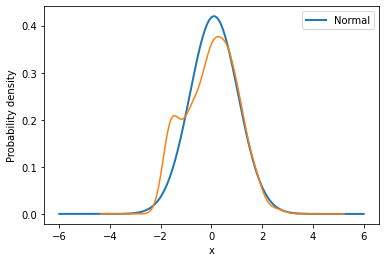

In [10]:
dist_norm(0.1, 0.95, trans(y))

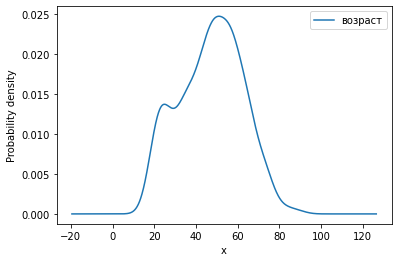

In [66]:
y.plot.kde()
plt.xlabel("x")
plt.ylabel("Probability density")
plt.legend()
plt.savefig('age_women.png')

In [65]:
plt.savefig('age_women.png')

<Figure size 432x288 with 0 Axes>

In [12]:
x_40 = df[df['возраст'] >= 40][['АДС', 'АДД', 'АДП',
       'ЗДВдох', 'ЗДВыдох', 'ЖЕЛ', 'Масса тела', 'Аккомодация',
       'Острота слуха', 'Стат.балансировка']]
y_40 = df[df['возраст'] >=40]['возраст']

### Ищем подходящее распределение для фичей

АДС

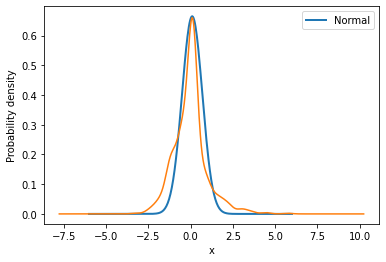

In [68]:
dist_norm(0.1, 0.6, trans(x_40['АДС']), 'ads_women.jpeg')

АДД

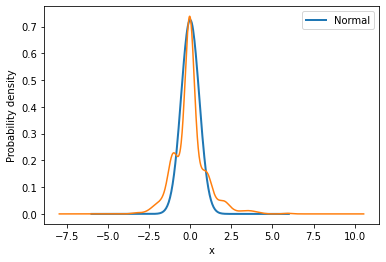

In [22]:
dist_norm(0.0, 0.55, trans(x_40['АДД']))

АДП

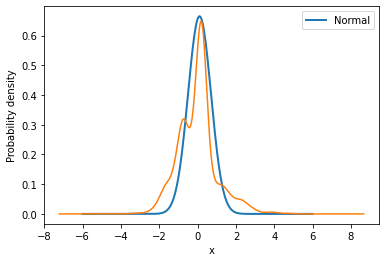

In [24]:
dist_norm(0.1, 0.6, trans(x_40['АДП']))

ЗДВдох

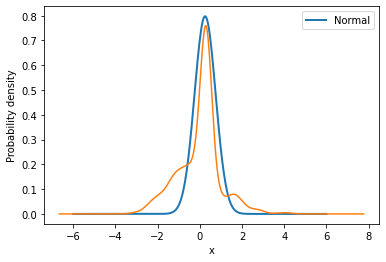

In [27]:
dist_norm(0.25, 0.5, trans(x_40['ЗДВдох']))

ЗДВыдох

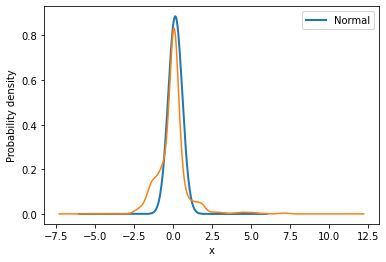

In [32]:
dist_norm(0.15, 0.45, trans(x_40['ЗДВыдох']))

ЖЕЛ

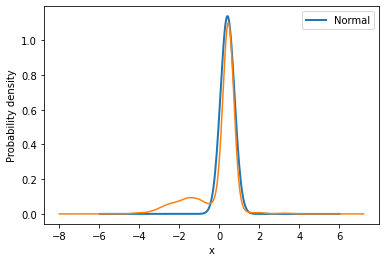

In [38]:
dist_norm(0.4, 0.35, trans(x_40['ЖЕЛ']))

Масса тела

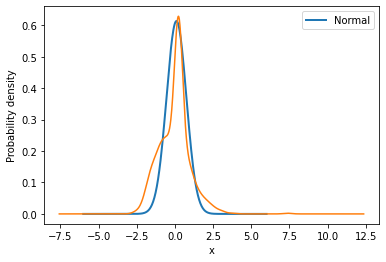

In [42]:
dist_norm(0.1, 0.65, trans(x_40['Масса тела']))

Аккомодация

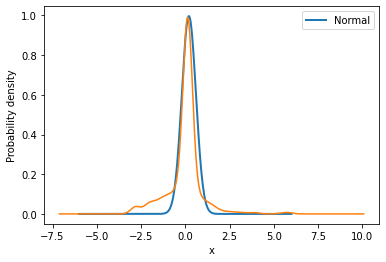

In [45]:
dist_norm(0.2, 0.4, trans(x_40['Аккомодация']))

Острота слуха

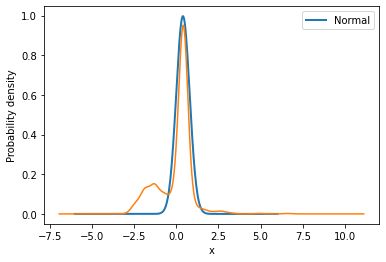

In [50]:
dist_norm(0.4, 0.4, trans(x_40['Острота слуха']))

Стат.балансировка

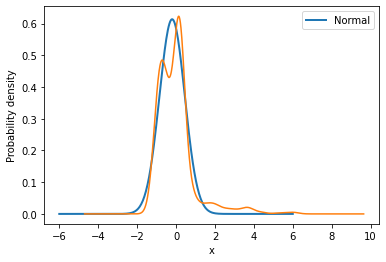

In [51]:
dist_norm(-0.2, 0.65, trans(x_40['Стат.балансировка']))

попробуем построить модель

In [52]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    ads = pm.Normal("ads", mu=0.1, sigma=0.6)
    add = pm.Normal('add', mu = 0, sigma = 0.55)
    adp = pm.Normal("adp", mu = 0.1, sigma = 0.6)
    zdin = pm.Normal("zdin", mu = 0.25, sigma = 0.5)
    zdout = pm.Normal("zdout", mu = 0.15, sigma = 0.45)
    gel = pm.Normal("gel", mu = 0.4, sigma = 0.35)
    massa = pm.Normal("massa", mu = 0.1, sigma = 0.65)
    akkom = pm.Normal("akkom", mu = 0.2, sigma = 0.4)
    sluh = pm.Normal("sluh", mu = 0.4, sigma = 0.4)
    balance = pm.Normal("balance", mu = -0.2, sigma = 0.65)
    epsilon = pm.Normal("epsilon", mu=0, sigma=1)
    

    # Expected value of outcome
    mu = epsilon + ads*trans(x_40['АДС']) + add*trans(x_40['АДД']) + adp*trans(x_40['АДП']) + zdin*trans(x_40['ЗДВдох']) + \
     zdout * trans(x_40['ЗДВыдох']) + gel * trans(x_40['ЖЕЛ']) + massa * trans(x_40['Масса тела']) + \
    akkom * trans(x_40['Аккомодация']) + sluh * trans(x_40['Острота слуха']) + balance * trans(x_40['Стат.балансировка'])
        

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=0.95, observed=trans(y_40))

In [53]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(2000, return_inferencedata=False)

C:\Users\Main\AppData\Roaming\Python\Python39\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Main\AppData\Roaming\Python\Python39\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ads, add, adp, zdin, zdout, gel, massa, akkom, sluh, balance, epsilon]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 136 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


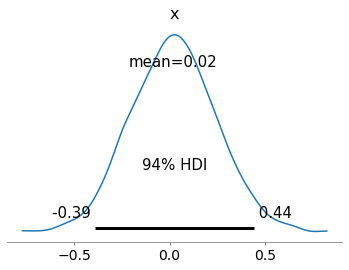

In [54]:
with basic_model:
    az.plot_posterior(trace['ads'])

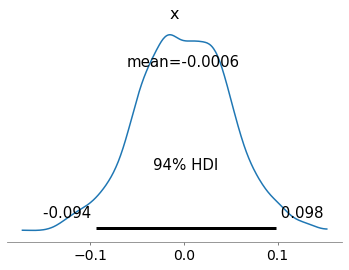

In [144]:
with basic_model:
    az.plot_posterior(trace['epsilon'])

In [55]:
# getting the mean values of the parameters as estimates:

var_weights = {}
pm.summary(trace['ads'])


arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.02,0.225,-0.391,0.444,0.005,0.004,2166.0,2191.0,NaN


In [56]:
column = ['ads', 'add', 'adp', 'zdin', 'zdout', 'gel', 'massa', 'akkom', 'sluh', 'balance']

In [57]:
var_weights['intercept'] = trace['epsilon'].mean()
for i, c in enumerate(column):
      var_weights[c] = trace[c].mean()
var_weights = pd.DataFrame(var_weights, index=[0])

# storing the standard deviation -> useful for plotting prediction distribution
# sd = trace['sigma'].mean()

In [58]:
var_weights

,intercept,ads,add,adp,zdin,zdout,gel,massa,akkom,sluh,balance
0,0.000026,0.020366,-0.035192,0.212492,-0.166317,0.044012,-0.08869,-0.073387,-0.10891,0.16226,-0.268446


In [59]:
var_weights['intercept'].values

array([2.56735665e-05])

In [60]:
bayes_test_set_scaled = np.append(np.ones((len(x_transformed), 1)), x_transformed, axis=1)
bayes_test_set_prediction_scaled = np.dot(bayes_test_set_scaled, np.array(var_weights).T)
bayes_test_set_prediction = scaller.inverse_transform(bayes_test_set_prediction_scaled)

In [61]:
from sklearn.metrics import accuracy_score, mean_absolute_error

In [62]:
mean_absolute_error(y, bayes_test_set_prediction)

12.181534280887497